In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../utilities')

import utilities as util
import augmentations as aug
import visualization as viz
from training_utilities import TrainingMetrics, TrainingTimer
import hist_correlation as histo
import glob
from astropy.io import fits
from random import randint
import matplotlib.pyplot as plt

2023-12-19 14:08:38.052619: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-19 14:08:38.076840: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 14:08:38.076864: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 14:08:38.077488: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-19 14:08:38.081599: I tensorflow/core/platform/cpu_feature_guar

In [2]:
train_images_list = glob.glob('../Results/LWIRISEG/Results/*Train*.fits')
val_images_list = glob.glob('../Results/LWIRISEG/Results/*Val*.fits')
print(len(train_images_list))
print(len(val_images_list))

200
200


In [3]:
train_fits = [util.open_fits_with_mask_and_pred(filename=f, DR=1) for f in train_images_list]
val_fits = [util.open_fits_with_mask_and_pred(filename=f, DR=1) for f in val_images_list]

In [5]:
# Process each FITS file and create histograms
histogram_data = [histo.process_data_and_create_histogram(fits_file) for fits_file in train_fits]
corr_matrix = histo.compute_correlation_matrix(histogram_data)


In [6]:
the_dict = histo.find_correlated_fits(corr_matrix,5,val_fits)

/home/wassim/Projects/kelian/infrared-cloud-detection/notebooks/../utilities/visualization.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


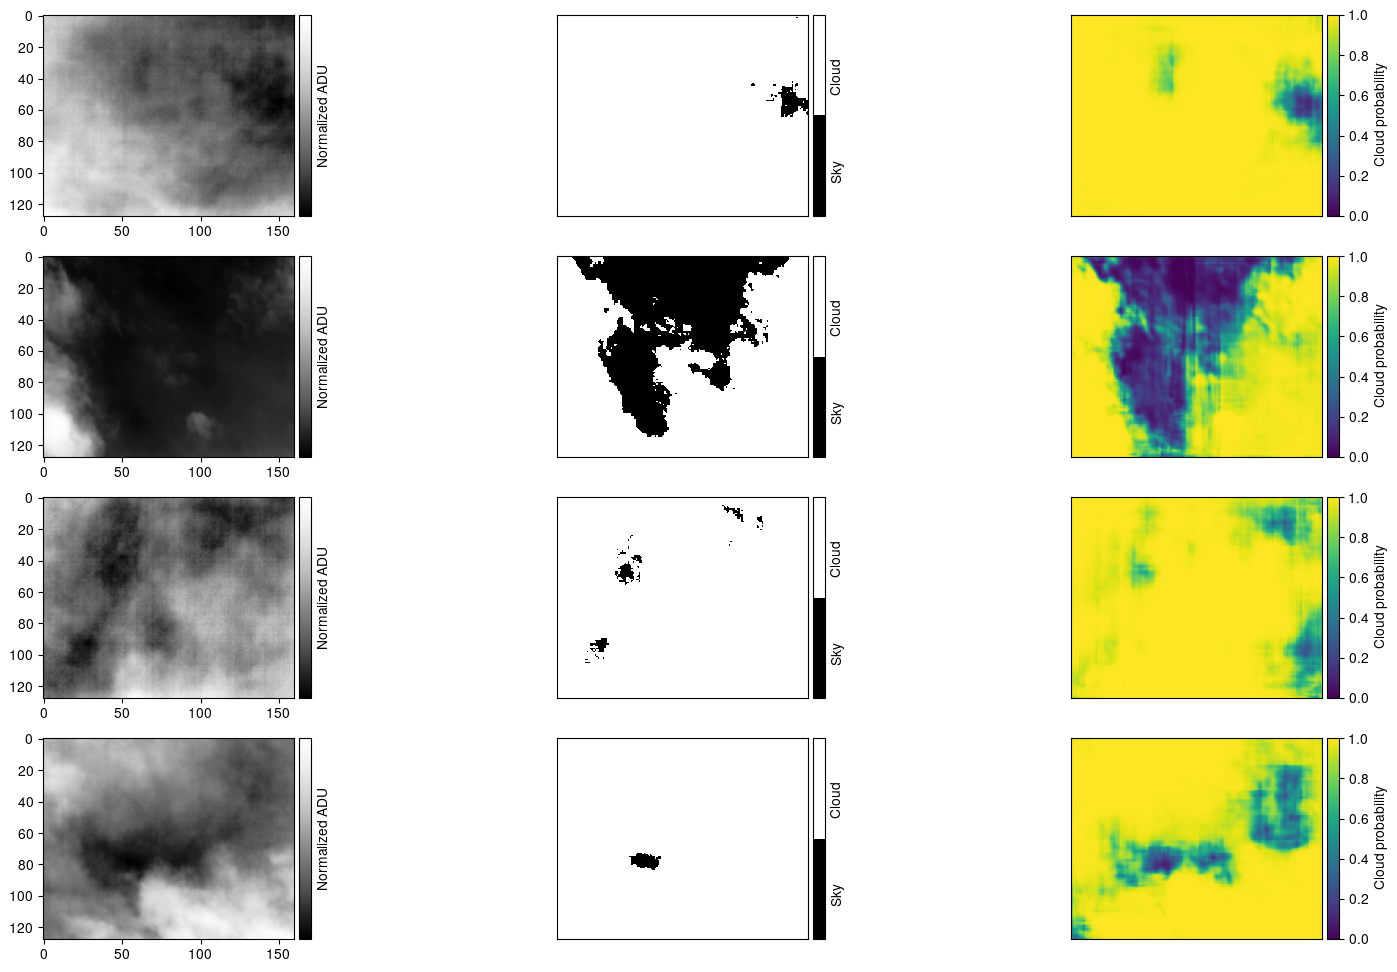

In [10]:
viz.plot_image_preds([the_dict["original"],*the_dict["least_correlated"]], figsize_per_row=(18,12), output_path=None)

/home/wassim/Projects/kelian/infrared-cloud-detection/notebooks/../utilities/visualization.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


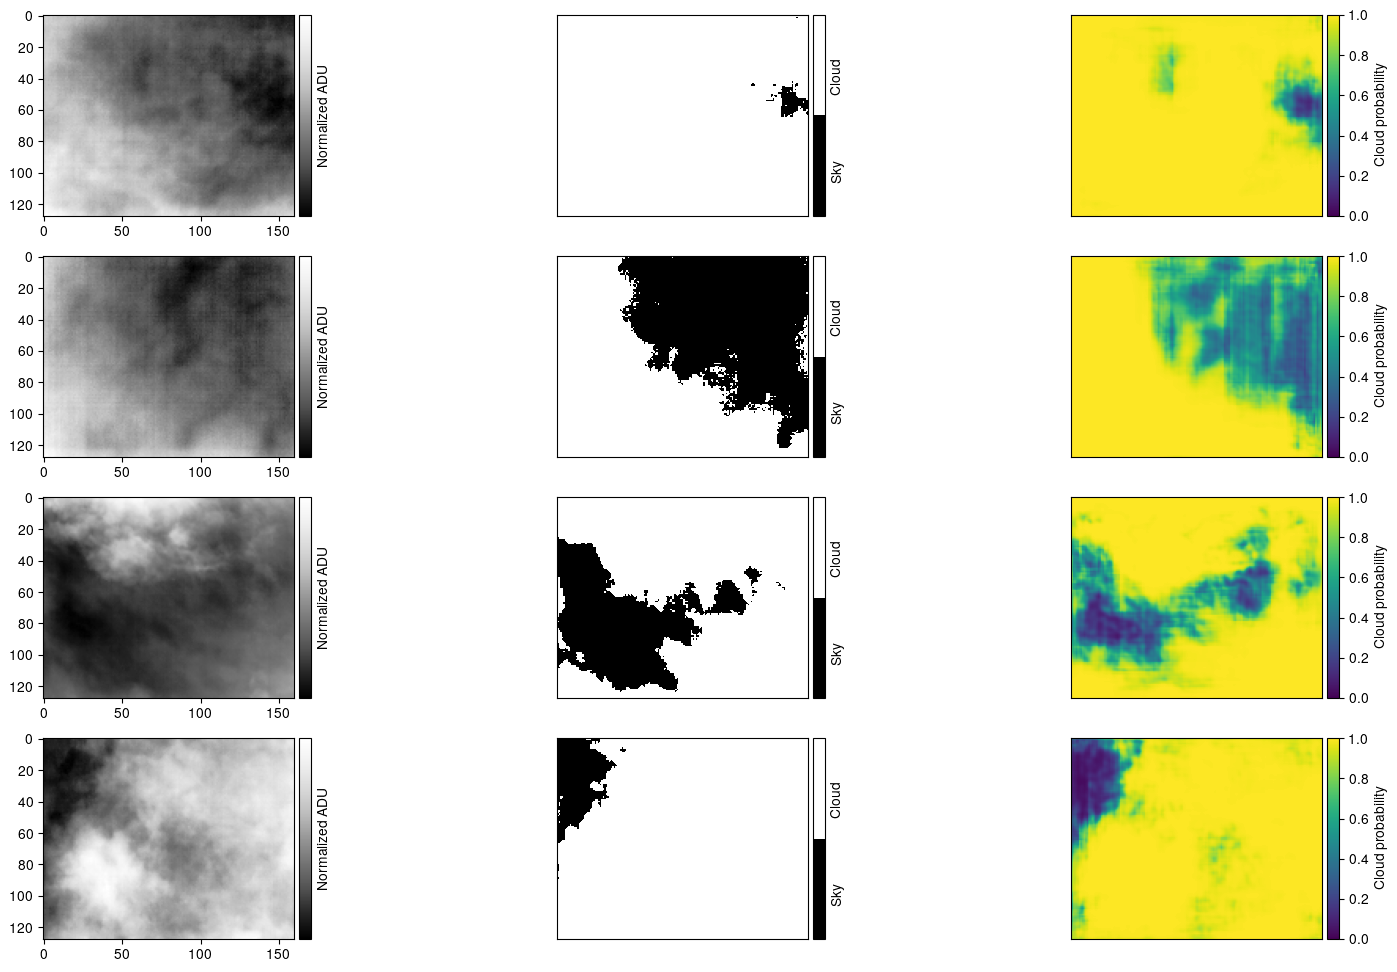

In [11]:
viz.plot_image_preds([the_dict["original"],*the_dict["most_correlated"]], figsize_per_row=(18,12), output_path=None)

In [54]:

from scipy import fftpack
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is
             None, which then uses the center of the image (including
             fracitonal pixels).

    """
    # Calculate the indices from the image
    y, x  = np.indices(image.shape[:2])

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin

    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

def compute_power_spectrum(filename,indx=0,show_plot=False,icmap='Greys_r'):
    try:
        l_img = fits.open(filename)  # Read FITS image data
        img = l_img[indx].data
        l_img.close()
    except:
        print(f"Error opening {filename}")
        return 1

    img = img/np.max(img)
    F = fftpack.fftshift(fftpack.fft2(img))  # Compute 2D FFT
    psd2D = np.abs(F)**2  # Compute 2D Power Spectrum
    psd1D = azimuthalAverage(psd2D)  # Compute azimuthally averaged 1D Power Spectrum

    if show_plot:
        # Create a single figure with three subplots arranged in 1 row and 3 columns
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        # Plot Image
        axs[0].imshow(np.log10(img), cmap=icmap)
        axs[0].set_title('Image')

        # Plot 2D Power Spectrum
        axs[1].imshow(np.log10(psd2D), cmap=plt.cm.viridis)
        axs[1].set_title('2D Power Spectrum')

        # Plot azimuthally averaged 1D Power Spectrum
        axs[2].plot(psd1D)
        axs[2].set_title('1D Power Spectrum')
        axs[2].set_yscale('symlog')

        plt.tight_layout()  # Adjust spacing between subplots
        plt.show()  # Show the combined plot

    return psd1D

In [13]:
train_images_list = glob.glob('../Results/LWIRISEG/Results/*Train*.fits')
val_images_list = glob.glob('../Results/LWIRISEG/Results/*Val*.fits')
print(len(train_images_list))
print(len(val_images_list))

200
200


In [14]:
train_fits = [util.open_fits_with_mask_and_pred(filename=f, DR=1) for f in train_images_list]
val_fits = [util.open_fits_with_mask_and_pred(filename=f, DR=1) for f in val_images_list]

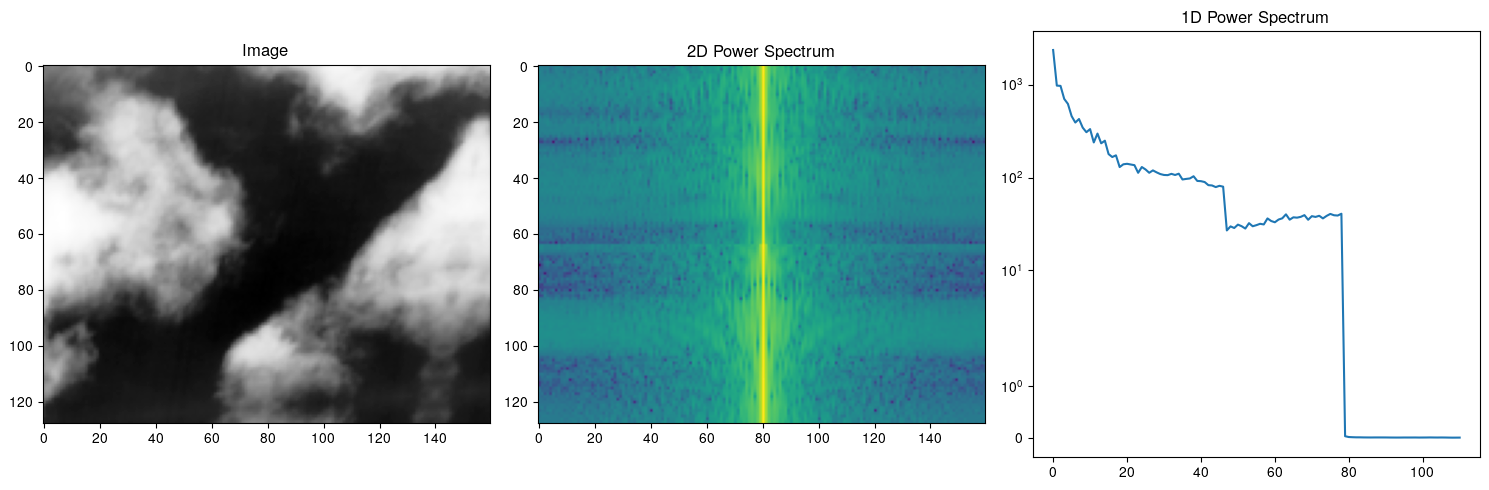

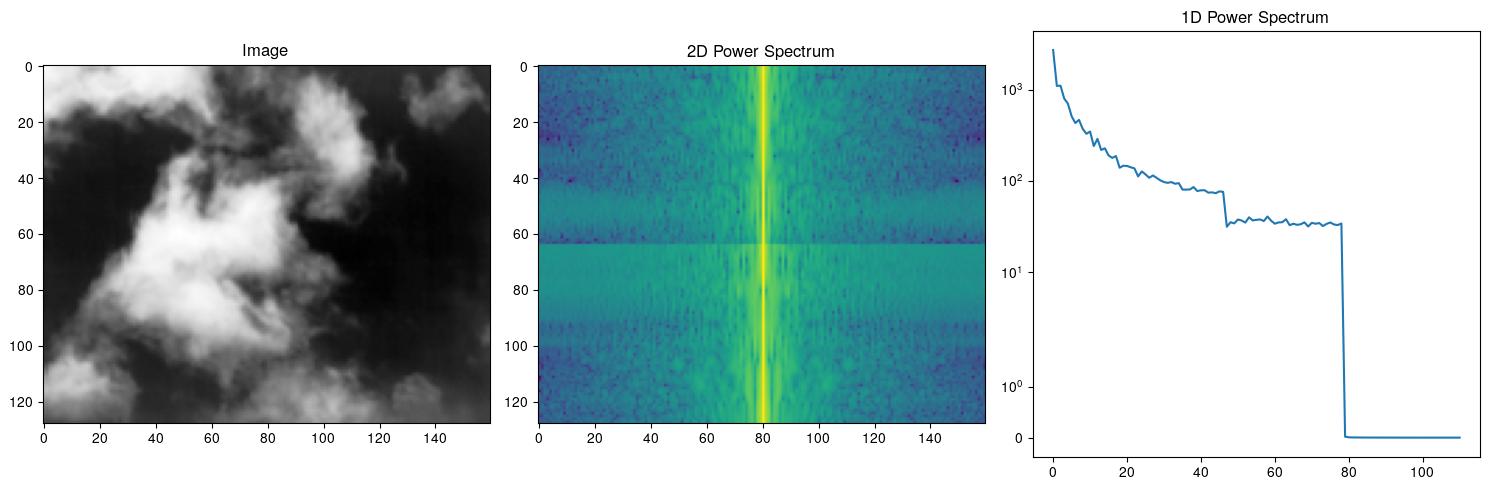

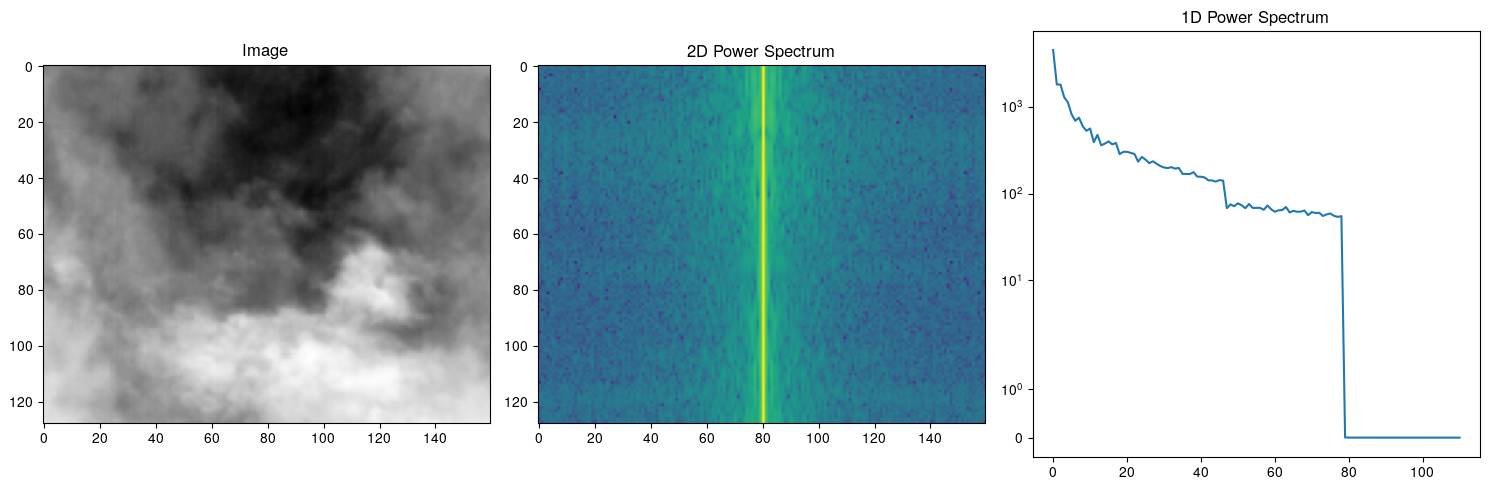

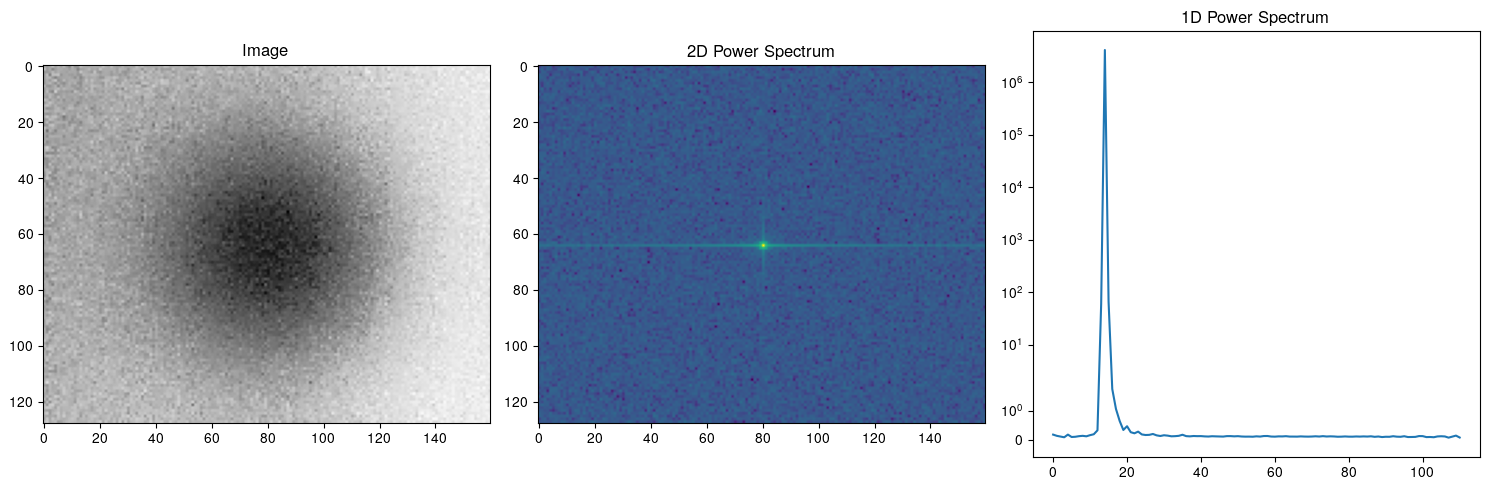

In [52]:
ps_cloud = compute_power_spectrum(train_images_list[28],show_plot=True)
ps_cloud2 = compute_power_spectrum(train_images_list[171],show_plot=True)
ps_cloud3 = compute_power_spectrum(train_images_list[41],show_plot=True)
ps_clear = compute_power_spectrum(f'/home/wassim/Data/CIRRUS/Classification/SIM_BIN_SUBSET/1_ADU_synthetic_sim_binned.fits',show_plot=True)

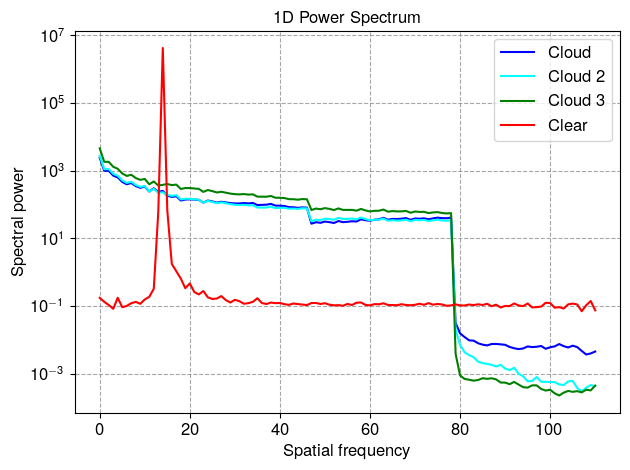

In [38]:
# Create figure and axis
fig, ax = plt.subplots()

ax.set_title('1D Power Spectrum')
ax.set_yscale('log')

ax.plot(ps_cloud, color='blue', label='Cloud')
ax.plot(ps_cloud2, color='cyan', label='Cloud 2')
ax.plot(ps_cloud3, color='green', label='Cloud 3')
ax.plot(ps_clear, color='red', label='Clear')

# Legend and labels
ax.legend(loc='best', fontsize='large', frameon=True)
ax.grid(True, linestyle='--', color='gray', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize='large')
ax.set_xlabel('Spatial frequency', fontsize='large')
ax.set_ylabel('Spectral power', fontsize='large')


plt.tight_layout()  # Adjust spacing between subplots
plt.show()  # Show the combined plot

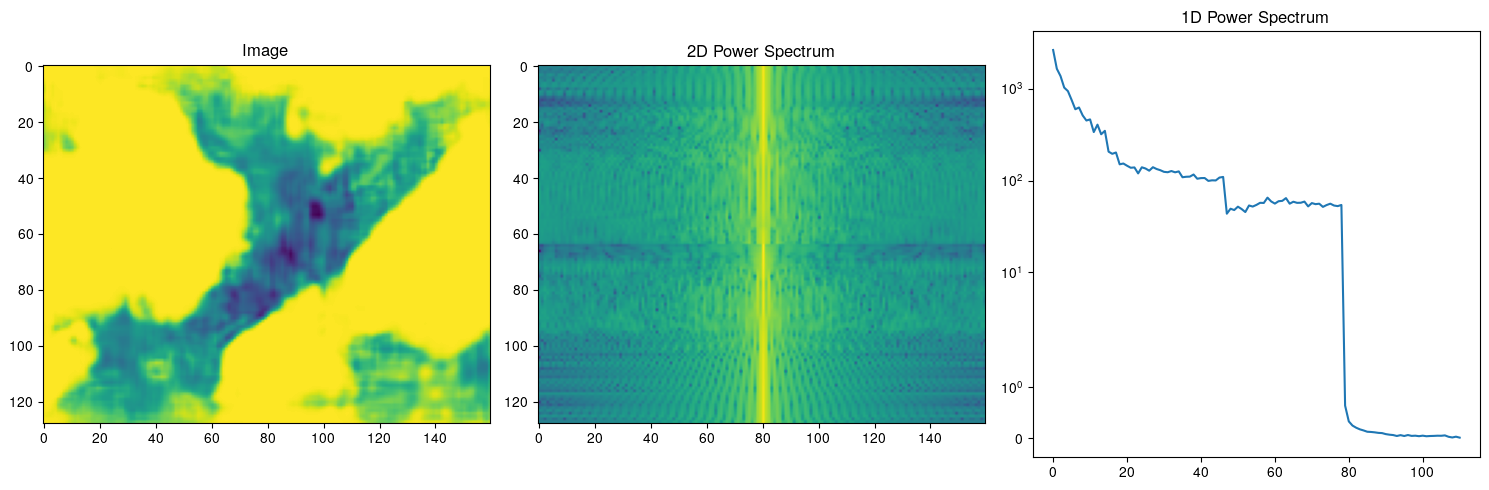

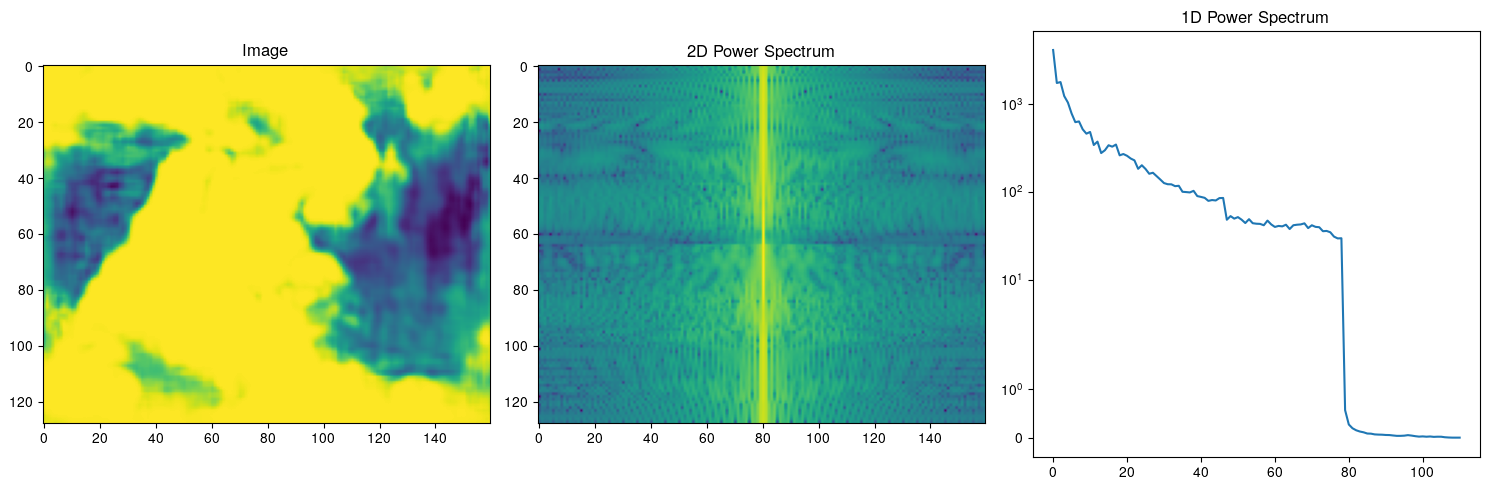

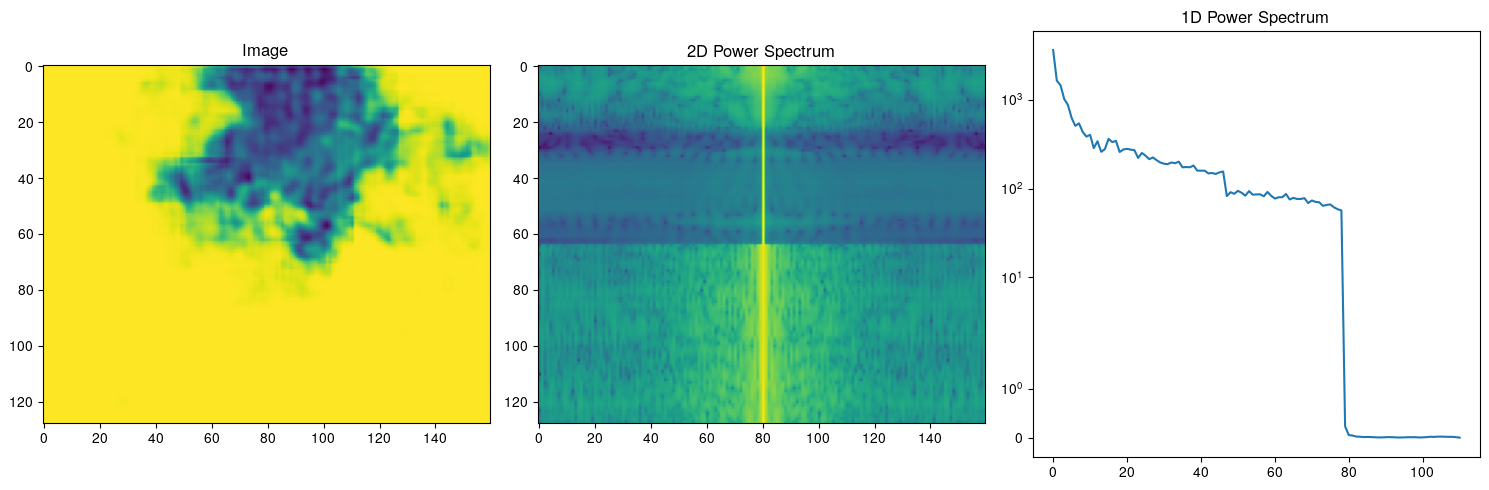

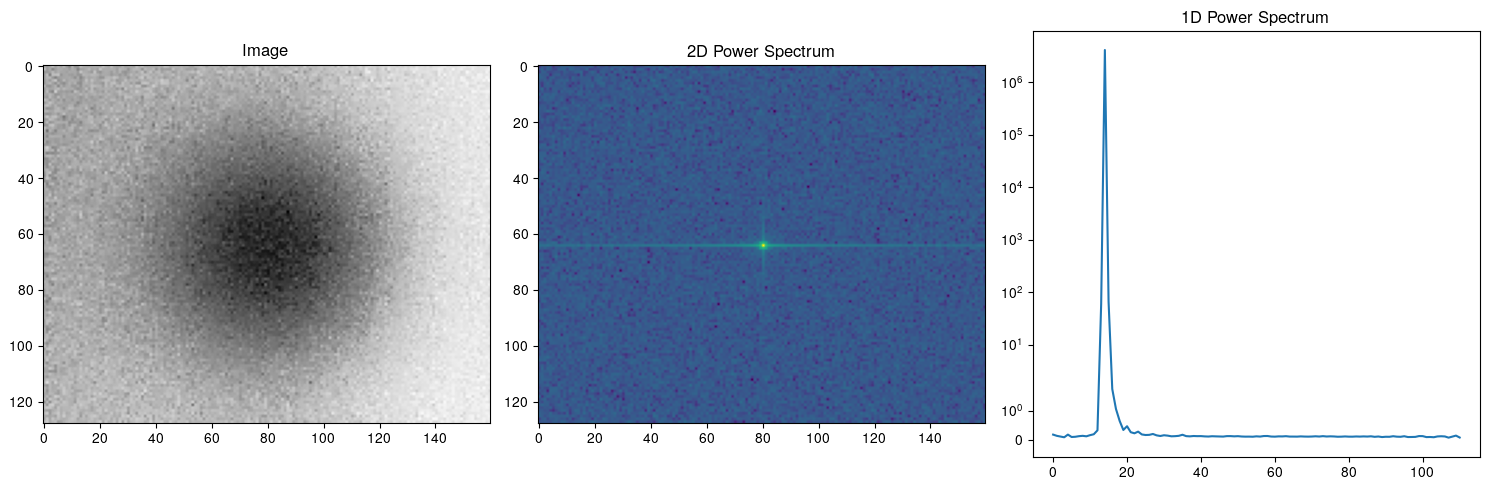

In [55]:
ps_cloud = compute_power_spectrum(train_images_list[28],indx=2,show_plot=True,icmap='viridis')
ps_cloud2 = compute_power_spectrum(train_images_list[171],indx=2,show_plot=True,icmap='viridis')
ps_cloud3 = compute_power_spectrum(train_images_list[41],indx=2,show_plot=True,icmap='viridis')
ps_clear = compute_power_spectrum(f'/home/wassim/Data/CIRRUS/Classification/SIM_BIN_SUBSET/1_ADU_synthetic_sim_binned.fits',show_plot=True)

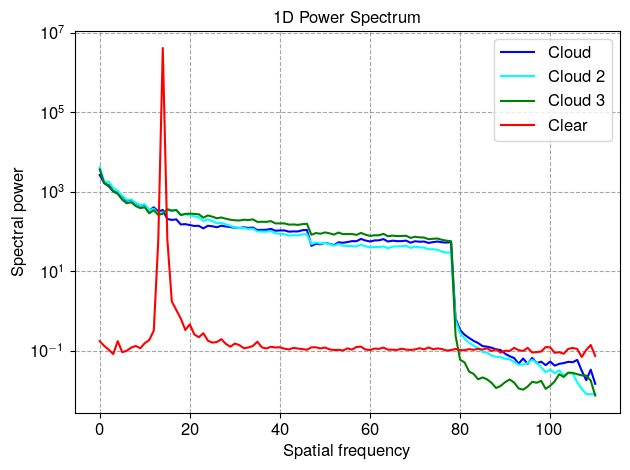

In [56]:
# Create figure and axis
fig, ax = plt.subplots()

ax.set_title('1D Power Spectrum')
ax.set_yscale('log')

ax.plot(ps_cloud, color='blue', label='Cloud')
ax.plot(ps_cloud2, color='cyan', label='Cloud 2')
ax.plot(ps_cloud3, color='green', label='Cloud 3')
ax.plot(ps_clear, color='red', label='Clear')

# Legend and labels
ax.legend(loc='best', fontsize='large', frameon=True)
ax.grid(True, linestyle='--', color='gray', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize='large')
ax.set_xlabel('Spatial frequency', fontsize='large')
ax.set_ylabel('Spectral power', fontsize='large')


plt.tight_layout()  # Adjust spacing between subplots
plt.show()  # Show the combined plot